In [2]:
import requests
import time
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from fractions import Fraction
import pandas
from webdriver_manager.chrome import ChromeDriverManager
import seaborn
import matplotlib.pyplot as plt

In [124]:
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/tobydrane/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache
<ipython-input-124-c026f0c15647>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [119]:
url = "https://www.oddsportal.com/soccer/england/premier-league-2015-2016/results/"
driver.get(url)
time.sleep(3)

In [120]:
soup = BeautifulSoup(driver.page_source, 'html.parser')
print(soup.prettify())

<html xml:lang="cs" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <script async="" crossorigin="anonymous" src="https://connect.facebook.net/en_US/all.js?hash=8daf61b5e62c00a3a988aa1b14765f48">
  </script>
  <script async="" id="facebook-jssdk" src="//connect.facebook.net/en_US/all.js#xfbml=1&amp;appId=393736670647047">
  </script>
  <script async="" src="https://www.google-analytics.com/analytics.js" type="text/javascript">
  </script>
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=G-5YY4JY41P1&amp;l=dataLayer&amp;cx=c" type="text/javascript">
  </script>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="Thu, 01 Jan 1970 00:59:59 GMT" http-equiv="expires"/>
  <meta content="no-cache" http-equiv="pragma"/>
  <meta content="no-cache" http-equiv="cache-control"/>
  <meta content="sport" property="og:type"/>
  <meta content="https://www.oddsportal.com/res/img/oddsportal.png" property="og:image"/>
  <meta content="Oddsportal.com"

In [32]:
def get_pages_list():
  div = soup.find(id='pagination')
  a = div.findAll('a')
  a_list = [item for item in a]
  final_item = a_list[-1]
  largest_pagination_value = int(final_item.get('x-page'))
  largest_pagination_value
  pages = [f'{url}/#/page/{i+1}' for i in range(largest_pagination_value)]
  return pages

pages = get_pages_list()
pages

AttributeError: 'NoneType' object has no attribute 'findAll'

In [33]:
def get_single_page_matches_links(soup):
  tt_div = soup.find(id='tournamentTable')
  tt_tbody = tt_div.find('tbody')
  urls = []
  for child in tt_tbody.childGenerator():
    is_link = child.get('xeid')
    if is_link:
      child_td = child.find(class_='name table-participant')
      child_td_a = child_td.find('a')
      urls.append(f'https://www.oddsportal.com{child_td_a.get("href")}')

  return urls

urls = get_single_page_matches_links(soup)
urls[:5]

['https://www.oddsportal.com/soccer/england/efl-trophy/bolton-fleetwood-town-E5uqK9Xb/',
 'https://www.oddsportal.com/soccer/england/efl-trophy/cambridge-utd-walsall-MVriIm2B/',
 'https://www.oddsportal.com/soccer/england/efl-trophy/carlisle-lincoln-city-xMo3FonU/',
 'https://www.oddsportal.com/soccer/england/efl-trophy/charlton-aston-villa-neeSFFcA/',
 'https://www.oddsportal.com/soccer/england/efl-trophy/forest-green-chelsea-jT1JHyTc/']

In [34]:
def parse_single_page(url):
  data = []

  driver.get(url)
  time.sleep(3)
  soup = BeautifulSoup(driver.page_source, 'html.parser')

  def fraction_to_float(string):
    return float(sum(Fraction(s) for s in string.split()))

  content = soup.find(id='col-content')
  game_name = str(content.find('h1').get_text())
  home = game_name.split('-')[0].strip()
  away = game_name.split('-')[1].strip()
  game_date = str(content.find('p').get_text())
  try:
    if str(content.find(class_='result').find('strong').get_text()):
      result_string = str(content.find(class_='result').find('strong').get_text())
      home_sore = int(result_string.split(':')[0])
      if ('penalties' in result_string.split(':')[1]):
        away_score = result_string.split(':')[1]
        away_score = int(away_score.split('penalties')[0])
      else:
        away_score = int(result_string.split(':')[1])
      if home_sore > away_score:
        winner = 'home'
      elif away_score > home_sore:
        winner = 'away'
      else:
        winner = 'draw'
    else:
      winner = None
  except Exception as e:
    winner = None

  odds_table = content.find(class_='table-main').find('tbody')
  for child in odds_table:
    tr_child = list(child.children)
    if (len(tr_child) > 4):
      bookie = str(tr_child[0].findAll('a')[1].get_text())

      home_odds_string = str(tr_child[1].find('div').get_text())
      home_odds = fraction_to_float(home_odds_string)

      draw_odds_string = str(tr_child[2].find('div').get_text())
      draw_odds = fraction_to_float(draw_odds_string)

      away_odds_string = str(tr_child[3].find('div').get_text())
      away_odds = fraction_to_float(away_odds_string)

      data_row = [game_date, game_name, home, away, bookie, home_odds, draw_odds, away_odds, winner]
      data.append(data_row)
  return np.asarray(data)

data = parse_single_page(urls[0])


AttributeError: 'NoneType' object has no attribute 'get_text'

In [427]:
data.shape

(8, 9)

In [428]:
url = "https://www.oddsportal.com/soccer/england/premier-league-2015-2016/results/"
driver.get(url)
time.sleep(3)

data = np.array([])

pages_to_scrape = get_pages_list()
print(len(pages_to_scrape))

8


In [35]:
def scrape_main(page_num):
  """
  url = "https://www.oddsportal.com/soccer/england/league-one-2020-2021/results/"
  driver.get(url)
  time.sleep(3)

  data = np.array([])

  pages_to_scrape = get_pages_list()
  """ 
  data = np.array([])
  # First paginate over all pages
  page = pages_to_scrape[page_num]
  # for page in pages_to_scrape:
  driver.get(page)
  time.sleep(10)
  soup = BeautifulSoup(driver.page_source, 'html.parser')

  # Second find all the matches in this current page
  matches_to_scrape = get_single_page_matches_links(soup)
  for match in matches_to_scrape:
    current_data = parse_single_page(match)
    if data.size != 0:
      data = np.concatenate((data, current_data))
    else:
      data = current_data
  
  return data

In [431]:
#for i in range(len(pages_to_scrape)):
i = 7
data = scrape_main(i)
df = pandas.DataFrame(data=data, columns=['date', 'game_name', 'home', 'away', 'bookie', 'home_odds', 'draw_odds', 'away_odds', 'winner'])
df.to_csv(f'2015-2016-pl-page-{i}.csv')

In [434]:
df1 = pandas.read_csv('./2016-2017-pl-page-0.csv')
df2 = pandas.read_csv('./2016-2017-pl-page-1.csv')
df3 = pandas.read_csv('./2016-2017-pl-page-2.csv')
df4 = pandas.read_csv('./2016-2017-pl-page-3.csv')
df5 = pandas.read_csv('./2016-2017-pl-page-4.csv')
df6 = pandas.read_csv('./2016-2017-pl-page-5.csv')
df7 = pandas.read_csv('./2016-2017-pl-page-6.csv')
df8 = pandas.read_csv('./2016-2017-pl-page-7.csv')
#df9 = pandas.read_csv('./2017-2018-pl-page-8.csv')
#df10 = pandas.read_csv('./2020-2021-page-9.csv')
#df11 = pandas.read_csv('./2020-2021-page-10.csv')
#df12 = pandas.read_csv('./2020-2021-page-11.csv')
df_total = pandas.concat([df1, df2, df3, df4, df5, df6, df7, df8])
df_total.shape

(3127, 10)

In [435]:
df_total.to_csv('2016-2017-pl-master.csv')

# Exploratory Data Analysis

In [64]:
#df8 = pandas.read_csv('2015-2016-pl-master.csv')
#df7 = pandas.read_csv('2016-2017-pl-master.csv')
#df1 = pandas.read_csv('2017-2018-pl-master.csv')
#df2 = pandas.read_csv('2018-2019-pl-master.csv')
#df3 = pandas.read_csv('2019-2020-pl-master.csv')
#df4 = pandas.read_csv('2020-2021-pl-master.csv')
#df5 = pandas.read_csv('2019-2020-l1-master.csv')
df6 = pandas.read_csv('2020-2021-l1-master.csv')

#df_total = pandas.concat([df1, df2, df3, df4, df5, df6, df7, df8])
df_total = df6
df_total['date'] = pandas.to_datetime(df_total['date'])

In [65]:
df_total.drop(labels=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)
df_total.dropna(inplace=True)

In [66]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6529 entries, 0 to 6547
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6529 non-null   datetime64[ns]
 1   game_name  6529 non-null   object        
 2   home       6529 non-null   object        
 3   away       6529 non-null   object        
 4   bookie     6529 non-null   object        
 5   home_odds  6529 non-null   float64       
 6   draw_odds  6529 non-null   float64       
 7   away_odds  6529 non-null   float64       
 8   winner     6529 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 510.1+ KB


In [67]:
df_total[:12]

date            game_name       home     away        bookie  \
0  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln         1xBet   
1  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln     Asianodds   
2  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln   bet-at-home   
3  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln        bet365   
4  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln  Betsensation   
5  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln          bwin   
6  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln       Coolbet   
7  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln       Curebet   
8  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln         GGBET   
9  2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln        Lasbet   
10 2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln   Marathonbet   
11 2021-05-30 15:00:00  Blackpool - Lincoln  Blackpool  Lincoln      Pinnacle   

    home_odds  draw_odds  away_odds winner  
0        1.67       2.40       1.81   home  
1        1.74       2.21       1.85   home  
2        1.65       2.05       1.70   home  
3        1.62       2.30       1.75   home  
4        1.65       2.07       1.73   home  
5        1.65       2.20       1.75   home  
6        1.80       2.20       1.77   home  
7        1.71       2.15       1.79   home  
8        1.53       2.46       1.63   home  
9        1.73       2.18       1.82   home  
10       1.67       2.40       1.81   home  
11       1.73       2.20       1.82   home

In [68]:
df_day = df_total[(df_total['date'] == '2015-08-08 12:45:00')]
# df_day[df_day.home == 'Wolves']
df_day

Empty DataFrame
Columns: [date, game_name, home, away, bookie, home_odds, draw_odds, away_odds, winner]
Index: []

In [69]:
seaborn.color_palette("crest", as_cmap=True)
seaborn.catplot(data=df_day, x='game_name', y='home_odds', hue='bookie', kind='bar', height=10, aspect=2/1)

ValueError: min() arg is an empty sequence

## Bookie Consensus Modelling

In [70]:
df = df_total.copy()
df_consensus = df.groupby(by=['date', 'game_name', 'winner']).mean().reset_index()
df_consensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       557 non-null    datetime64[ns]
 1   game_name  557 non-null    object        
 2   winner     557 non-null    object        
 3   home_odds  557 non-null    float64       
 4   draw_odds  557 non-null    float64       
 5   away_odds  557 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 26.2+ KB


In [71]:
df_consensus.tail()

date               game_name winner  home_odds  draw_odds  \
552 2021-05-18 18:00:00  Oxford Utd - Blackpool   away   1.367692   2.066923   
553 2021-05-19 18:00:00    Lincoln - Sunderland   home   1.807692   1.989231   
554 2021-05-21 19:45:00  Blackpool - Oxford Utd   draw   1.380769   2.393077   
555 2021-05-22 15:30:00    Sunderland - Lincoln   home   0.791538   2.813077   
556 2021-05-30 15:00:00     Blackpool - Lincoln   home   1.674615   2.232308   

     away_odds  
552   2.255385  
553   1.732308  
554   1.949231  
555   3.363077  
556   1.752308

In [72]:
df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')

<ipython-input-72-b313a3583b16>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')


In [73]:
df_max['max_home_bookie'] = None
df_max['max_draw_bookie'] = None
df_max['max_away_bookie'] = None
for i in df_max.groupby(by=['date', 'game_name']):
  (a, b) = i
  (c, d) = a

  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_home_bookie'] = b['bookie'][(b['home_odds'] == b['home_odds_max'])].any()
  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_draw_bookie'] = b['bookie'][(b['draw_odds'] == b['draw_odds_max'])].any()
  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_away_bookie'] = b['bookie'][(b['away_odds'] == b['away_odds_max'])].any()

In [74]:
df_max.tail()

date           game_name     home      away        bookie  \
6543 2020-09-12 15:00:00  Swindon - Rochdale  Swindon  Rochdale         GGBET   
6544 2020-09-12 15:00:00  Swindon - Rochdale  Swindon  Rochdale   Marathonbet   
6545 2020-09-12 15:00:00  Swindon - Rochdale  Swindon  Rochdale      Pinnacle   
6546 2020-09-12 15:00:00  Swindon - Rochdale  Swindon  Rochdale        Unibet   
6547 2020-09-12 15:00:00  Swindon - Rochdale  Swindon  Rochdale  William Hill   

      home_odds  draw_odds  away_odds winner  home_odds_max  away_odds_max  \
6543       0.92       2.73       2.57   home           1.06           2.91   
6544       1.00       2.78       2.84   home           1.06           2.91   
6545       1.01       2.62       2.91   home           1.06           2.91   
6546       0.92       2.65       2.75   home           1.06           2.91   
6547       0.95       2.40       2.60   home           1.06           2.91   

      draw_odds_max max_home_bookie max_draw_bookie max_away_bookie  
6543           2.78         Coolbet           1xBet       Asianodds  
6544           2.78         Coolbet           1xBet       Asianodds  
6545           2.78         Coolbet           1xBet       Asianodds  
6546           2.78         Coolbet           1xBet       Asianodds  
6547           2.78         Coolbet           1xBet       Asianodds

In [75]:
df_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6529 entries, 0 to 6547
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             6529 non-null   datetime64[ns]
 1   game_name        6529 non-null   object        
 2   home             6529 non-null   object        
 3   away             6529 non-null   object        
 4   bookie           6529 non-null   object        
 5   home_odds        6529 non-null   float64       
 6   draw_odds        6529 non-null   float64       
 7   away_odds        6529 non-null   float64       
 8   winner           6529 non-null   object        
 9   home_odds_max    6529 non-null   float64       
 10  away_odds_max    6529 non-null   float64       
 11  draw_odds_max    6529 non-null   float64       
 12  max_home_bookie  6529 non-null   object        
 13  max_draw_bookie  6529 non-null   object        
 14  max_away_bookie  6529 non-null   object 

In [76]:
df_consensus = df_max.groupby(by=['date', 'game_name', 'winner', 'max_draw_bookie',	'max_away_bookie',	'max_home_bookie'], as_index=False).mean().reset_index()
df_consensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            557 non-null    int64         
 1   date             557 non-null    datetime64[ns]
 2   game_name        557 non-null    object        
 3   winner           557 non-null    object        
 4   max_draw_bookie  557 non-null    object        
 5   max_away_bookie  557 non-null    object        
 6   max_home_bookie  557 non-null    object        
 7   home_odds        557 non-null    float64       
 8   draw_odds        557 non-null    float64       
 9   away_odds        557 non-null    float64       
 10  home_odds_max    557 non-null    float64       
 11  away_odds_max    557 non-null    float64       
 12  draw_odds_max    557 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 56.7+ KB


In [77]:
df_consensus = df_consensus.sort_values(by='date', ascending=True).reset_index()
df_consensus.head()

level_0  index                date                    game_name winner  \
0        0      0 2020-09-12 15:00:00    Accrington - Peterborough   home   
1       10     10 2020-09-12 15:00:00           Swindon - Rochdale   home   
2        9      9 2020-09-12 15:00:00  Sunderland - Bristol Rovers   draw   
3        7      7 2020-09-12 15:00:00         Plymouth - Blackpool   home   
4        6      6 2020-09-12 15:00:00  Northampton - AFC Wimbledon   draw   

  max_draw_bookie max_away_bookie max_home_bookie  home_odds  draw_odds  \
0           1xBet         Coolbet       Asianodds   2.381818   2.604545   
1           1xBet       Asianodds         Coolbet   0.968182   2.618182   
2           GGBET     Marathonbet           1xBet   0.630000   2.799091   
3           1xBet           1xBet         Coolbet   1.821818   2.496364   
4           1xBet           1xBet         Coolbet   1.333636   2.359091   

   away_odds  home_odds_max  away_odds_max  draw_odds_max  
0   1.094545           2.54           1.17           2.80  
1   2.753636           1.06           2.91           2.78  
2   4.740909           0.69           5.10           2.94  
3   1.446364           1.93           1.50           2.68  
4   2.086364           1.42           2.16           2.48

# Betting Strategy

In [90]:
def expected_payout(df, result):
  alpha = 0.05
  p_consensus = (1 / df[f'{result}_odds'])
  return (p_consensus - alpha) * df[f'{result}_odds_max'] - 1

_df = df_consensus

home_expected_payout = expected_payout(_df, 'home')
draw_expected_payout = expected_payout(_df, 'draw')
away_expected_payout = expected_payout(_df, 'away')

expected_payouts = pandas.DataFrame({
  'payout0': home_expected_payout,
  'payout1': away_expected_payout,
  'payout2': draw_expected_payout
})

#print(expected_payouts)

# Highest payout per match
highest_expected_payout = np.max(expected_payouts, axis = 1)
# Indexed column of highest payout
highest_column = 1 + np.argmax(np.array(expected_payouts), axis = 1)

col_matcher = {
  1: 'max_home_bookie',
  2: 'max_away_bookie',
  3: 'max_draw_bookie'
}
bookie_list = ['bet-at-home', 'William Hill', 'bwin', 'Coolbet', 'GGBET', 'Marathonbet', 'Pinnacle', 'Unibet']

bets = []
for ix, i in enumerate(highest_column):
  if highest_expected_payout.values[ix] > 0:
    if i > 0:
      bookie_to_bet_with = df_consensus.iloc[[ix]][col_matcher[i]].values[0]
      if any(ext in bookie_to_bet_with for ext in bookie_list):
        pass
      else:
        i = 0
      bets.append(i)
  else:
    bets.append(0)

# Bet Results
# 0 - No Bet
# 1 - Home
# 2 - Away
# 3 - Draw
_df['bet_result'] = bets
_df

level_0  index                date                    game_name winner  \
0          0      0 2020-09-12 15:00:00    Accrington - Peterborough   home   
1         10     10 2020-09-12 15:00:00           Swindon - Rochdale   home   
2          9      9 2020-09-12 15:00:00  Sunderland - Bristol Rovers   draw   
3          7      7 2020-09-12 15:00:00         Plymouth - Blackpool   home   
4          6      6 2020-09-12 15:00:00  Northampton - AFC Wimbledon   draw   
..       ...    ...                 ...                          ...    ...   
552      552    552 2021-05-18 18:00:00       Oxford Utd - Blackpool   away   
553      553    553 2021-05-19 18:00:00         Lincoln - Sunderland   home   
554      554    554 2021-05-21 19:45:00       Blackpool - Oxford Utd   draw   
555      555    555 2021-05-22 15:30:00         Sunderland - Lincoln   home   
556      556    556 2021-05-30 15:00:00          Blackpool - Lincoln   home   

    max_draw_bookie max_away_bookie max_home_bookie  home_odds  draw_odds  \
0             1xBet         Coolbet       Asianodds   2.381818   2.604545   
1             1xBet       Asianodds         Coolbet   0.968182   2.618182   
2             GGBET     Marathonbet           1xBet   0.630000   2.799091   
3             1xBet           1xBet         Coolbet   1.821818   2.496364   
4             1xBet           1xBet         Coolbet   1.333636   2.359091   
..              ...             ...             ...        ...        ...   
552           GGBET     Marathonbet           GGBET   1.367692   2.066923   
553     Marathonbet          Lasbet     Marathonbet   1.807692   1.989231   
554       Asianodds            bwin         Coolbet   1.380769   2.393077   
555       Asianodds          bet365           1xBet   0.791538   2.813077   
556           GGBET       Asianodds         Coolbet   1.674615   2.232308   

     away_odds  home_odds_max  away_odds_max  draw_odds_max  bet_result  
0     1.094545           2.54           1.17           2.80           2  
1     2.753636           1.06           2.91           2.78           1  
2     4.740909           0.69           5.10           2.94           0  
3     1.446364           1.93           1.50           2.68           0  
4     2.086364           1.42           2.16           2.48           0  
..         ...            ...            ...            ...         ...  
552   2.255385           1.45           2.55           2.21           2  
553   1.732308           1.90           1.85           2.20           0  
554   1.949231           1.48           2.10           2.53           0  
555   3.363077           0.84           3.75           2.99           0  
556   1.752308           1.80           1.85           2.46           0  

[557 rows x 15 columns]

In [91]:
max_odds_columns = _df.iloc[:, [10, 11, 12]]
max_odds = []

_df['home_win'] = _df.winner == 'home'
_df['away_win'] = _df.winner == 'away'
_df['draw'] = _df.winner == 'draw'
_df['result'] = _df.home_win + 2 * _df.away_win + 3 * _df.draw

for i, j in zip(max_odds_columns.values, _df.result):
  max_odds.append((i[j-1]) + 1)

_df['max_odds'] = max_odds
_df

level_0  index                date                    game_name winner  \
0          0      0 2020-09-12 15:00:00    Accrington - Peterborough   home   
1         10     10 2020-09-12 15:00:00           Swindon - Rochdale   home   
2          9      9 2020-09-12 15:00:00  Sunderland - Bristol Rovers   draw   
3          7      7 2020-09-12 15:00:00         Plymouth - Blackpool   home   
4          6      6 2020-09-12 15:00:00  Northampton - AFC Wimbledon   draw   
..       ...    ...                 ...                          ...    ...   
552      552    552 2021-05-18 18:00:00       Oxford Utd - Blackpool   away   
553      553    553 2021-05-19 18:00:00         Lincoln - Sunderland   home   
554      554    554 2021-05-21 19:45:00       Blackpool - Oxford Utd   draw   
555      555    555 2021-05-22 15:30:00         Sunderland - Lincoln   home   
556      556    556 2021-05-30 15:00:00          Blackpool - Lincoln   home   

    max_draw_bookie max_away_bookie max_home_bookie  home_odds  draw_odds  \
0             1xBet         Coolbet       Asianodds   2.381818   2.604545   
1             1xBet       Asianodds         Coolbet   0.968182   2.618182   
2             GGBET     Marathonbet           1xBet   0.630000   2.799091   
3             1xBet           1xBet         Coolbet   1.821818   2.496364   
4             1xBet           1xBet         Coolbet   1.333636   2.359091   
..              ...             ...             ...        ...        ...   
552           GGBET     Marathonbet           GGBET   1.367692   2.066923   
553     Marathonbet          Lasbet     Marathonbet   1.807692   1.989231   
554       Asianodds            bwin         Coolbet   1.380769   2.393077   
555       Asianodds          bet365           1xBet   0.791538   2.813077   
556           GGBET       Asianodds         Coolbet   1.674615   2.232308   

     away_odds  home_odds_max  away_odds_max  draw_odds_max  bet_result  \
0     1.094545           2.54           1.17           2.80           2   
1     2.753636           1.06           2.91           2.78           1   
2     4.740909           0.69           5.10           2.94           0   
3     1.446364           1.93           1.50           2.68           0   
4     2.086364           1.42           2.16           2.48           0   
..         ...            ...            ...            ...         ...   
552   2.255385           1.45           2.55           2.21           2   
553   1.732308           1.90           1.85           2.20           0   
554   1.949231           1.48           2.10           2.53           0   
555   3.363077           0.84           3.75           2.99           0   
556   1.752308           1.80           1.85           2.46           0   

     home_win  away_win   draw  result  max_odds  
0        True     False  False       1  2.094545  
1        True     False  False       1  3.753636  
2       False     False   True       3  6.100000  
3        True     False  False       1  2.446364  
4       False     False   True       3  3.160000  
..        ...       ...    ...     ...       ...  
552     False      True  False       2  2.450000  
553      True     False  False       1  2.732308  
554     False     False   True       3  3.100000  
555      True     False  False       1  4.363077  
556      True     False  False       1  2.752308  

[557 rows x 20 columns]

In [94]:
# Remove no betted games
bet_df = _df.iloc[:][_df.bet_result > 0]
number_of_bets = len(bet_df)

bet_amount = 100

bet_df['win'] = bet_df.bet_result == bet_df.result
bet_df['payoff'] = ((bet_df.win) * bet_df.max_odds) - 1
bet_df['gain'] = (bet_df.payoff * bet_amount)
bet_df['cumulative'] = bet_df.gain.cumsum()

print(bet_df['win'].value_counts())

bet_df

True     71
False    58
Name: win, dtype: int64


level_0  index                date                  game_name winner  \
0          0      0 2020-09-12 15:00:00  Accrington - Peterborough   home   
1         10     10 2020-09-12 15:00:00         Swindon - Rochdale   home   
5          8      8 2020-09-12 15:00:00    Portsmouth - Shrewsbury   draw   
8          2      2 2020-09-12 15:00:00        Doncaster - MK Dons   draw   
14        21     21 2020-09-19 15:00:00   Shrewsbury - Northampton   away   
..       ...    ...                 ...                        ...    ...   
538      538    538 2021-05-04 19:00:00         Charlton - Lincoln   home   
545      544    544 2021-05-09 12:00:00      Gillingham - Plymouth   home   
548      548    548 2021-05-09 12:00:00        Oxford Utd - Burton   home   
549      549    549 2021-05-09 12:00:00    Portsmouth - Accrington   away   
552      552    552 2021-05-18 18:00:00     Oxford Utd - Blackpool   away   

    max_draw_bookie max_away_bookie max_home_bookie  home_odds  draw_odds  \
0             1xBet         Coolbet       Asianodds   2.381818   2.604545   
1             1xBet       Asianodds         Coolbet   0.968182   2.618182   
5             1xBet          bet365         Coolbet   0.810000   2.477273   
8             1xBet       Asianodds         Coolbet   1.113636   2.279091   
14         Pinnacle          bet365         Coolbet   0.913000   2.547000   
..              ...             ...             ...        ...        ...   
538     Marathonbet       Asianodds     Marathonbet   1.003571   2.493571   
545           1xBet            bwin     Marathonbet   0.831429   2.990714   
548          Lasbet          bet365            bwin   0.540714   3.491429   
549          Unibet          bet365     Marathonbet   0.568571   3.290000   
552           GGBET     Marathonbet           GGBET   1.367692   2.066923   

     ...  bet_result  home_win  away_win   draw  result  max_odds    win  \
0    ...           2      True     False  False       1  2.094545  False   
1    ...           1      True     False  False       1  3.753636   True   
5    ...           1     False     False   True       3  5.000000  False   
8    ...           1     False     False   True       3  3.940000  False   
14   ...           1     False      True  False       2  1.960000  False   
..   ...         ...       ...       ...    ...     ...       ...    ...   
538  ...           1      True     False  False       1  3.747143   True   
545  ...           1      True     False  False       1  3.980714   True   
548  ...           1      True     False  False       1  5.622857   True   
549  ...           1     False      True  False       2  1.620000  False   
552  ...           2     False      True  False       2  2.450000   True   

       payoff        gain    cumulative  
0   -1.000000 -100.000000   -100.000000  
1    2.753636  275.363636    175.363636  
5   -1.000000 -100.000000     75.363636  
8   -1.000000 -100.000000    -24.636364  
14  -1.000000 -100.000000   -124.636364  
..        ...         ...           ...  
538  2.747143  274.714286  18500.008442  
545  2.980714  298.071429  18798.079870  
548  4.622857  462.285714  19260.365584  
549 -1.000000 -100.000000  19160.365584  
552  1.450000  145.000000  19305.365584  

[129 rows x 24 columns]

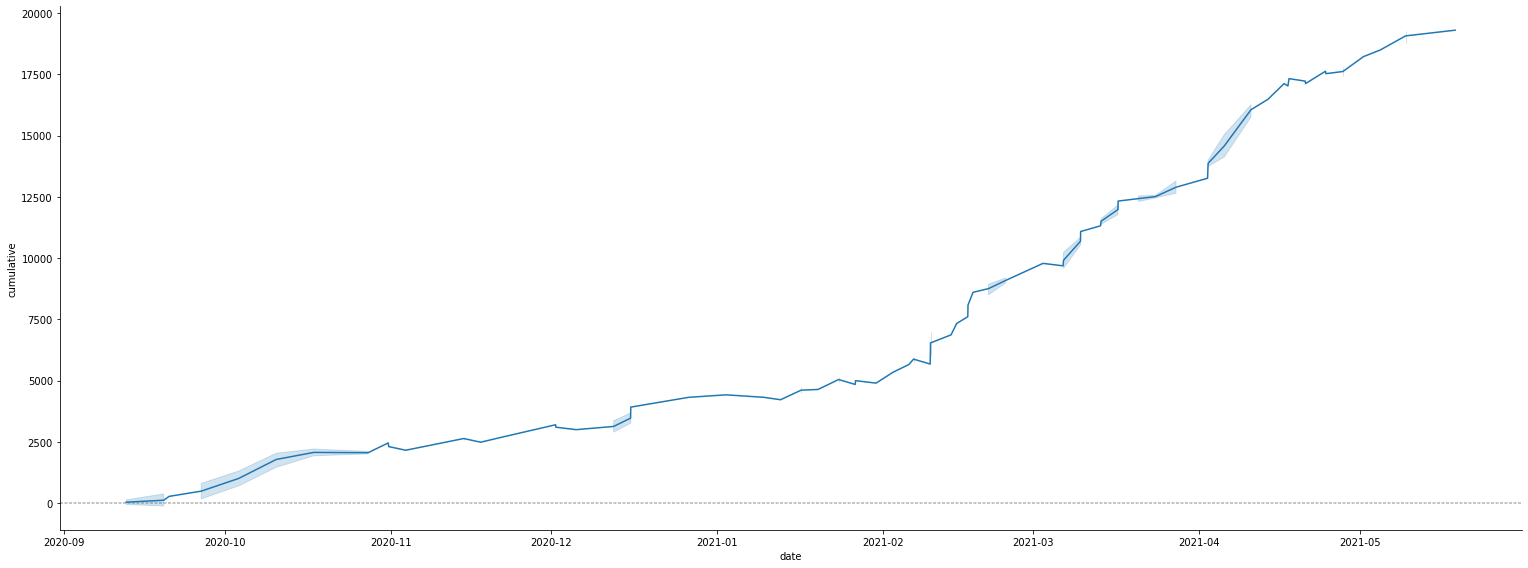

In [95]:
g = seaborn.relplot(data=bet_df, x='date', y='cumulative', kind='line', height=8, aspect=8/3)
(g.map(plt.axhline, y=0, color='0.7', dashes=(2, 1), zorder=0))

In [23]:
mdl_accuracy = round(sum(bet_df.win)/number_of_bets,3)
print(f'Accuracy of bets: {mdl_accuracy}')
 
mdl_profit = bet_df.cumulative.iloc[-1]
f'Profit of {mdl_profit} dollars generated on historical data.'

Accuracy of bets: 0.529


'Profit of 474.44304445554434 dollars generated on historical data.'

In [96]:
todays_url = 'https://www.oddsportal.com/soccer/england/efl-trophy/'

def parse_single_page(url):
  data = []

  driver.get(url)
  time.sleep(3)
  soup = BeautifulSoup(driver.page_source, 'html.parser')

  def fraction_to_float(string):
    return float(sum(Fraction(s) for s in string.split()))

  content = soup.find(id='col-content')
  game_name = str(content.find('h1').get_text())
  home = game_name.split('-')[0].strip()
  away = game_name.split('-')[1].strip()
  game_date = str(content.find('p').get_text())
  try:
    if str(content.find(class_='result').find('strong').get_text()):
      result_string = str(content.find(class_='result').find('strong').get_text())
      home_sore = int(result_string.split(':')[0])
      if ('penalties' in result_string.split(':')[1]):
        away_score = result_string.split(':')[1]
        away_score = int(away_score.split('penalties')[0])
      else:
        away_score = int(result_string.split(':')[1])
      if home_sore > away_score:
        winner = 'home'
      elif away_score > home_sore:
        winner = 'away'
      else:
        winner = 'draw'
    else:
      winner = None
  except Exception as e:
    winner = None

  odds_table = content.find(class_='table-main').find('tbody')
  for child in odds_table:
    tr_child = list(child.children)
    if (len(tr_child) > 4):
      bookie = str(tr_child[0].findAll('a')[1].get_text())
      
      try:
        home_odds_string = str(tr_child[1].find('div').get_text())
      except Exception:
        home_odds_string = str(tr_child[1].find('a').get_text())
      home_odds = fraction_to_float(home_odds_string)

      try:
        draw_odds_string = str(tr_child[2].find('div').get_text())
      except Exception:
        draw_odds_string = str(tr_child[2].find('a').get_text())
      draw_odds = fraction_to_float(draw_odds_string)

      try:
        away_odds_string = str(tr_child[3].find('div').get_text())
      except Exception:
        away_odds_string = str(tr_child[3].find('a').get_text())
      away_odds = fraction_to_float(away_odds_string)

      data_row = [game_date, game_name, home, away, bookie, home_odds, draw_odds, away_odds, winner]
      data.append(data_row)
  return np.asarray(data)

data = parse_single_page(urls[0])

def run_today_scrape(url):
  driver.get(url)
  time.sleep(3)
  data = np.array([])
  matches_to_scrape = get_single_page_matches_links(soup)
  for match in matches_to_scrape:
    current_data = parse_single_page(match)
    if data.size != 0:
      data = np.concatenate((data, current_data))
    else:
      data = current_data
  
  return data

data = run_today_scrape(todays_url)
df = pandas.DataFrame(data=data, columns=['date', 'game_name', 'home', 'away', 'bookie', 'home_odds', 'draw_odds', 'away_odds', 'winner'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       195 non-null    object
 1   game_name  195 non-null    object
 2   home       195 non-null    object
 3   away       195 non-null    object
 4   bookie     195 non-null    object
 5   home_odds  195 non-null    object
 6   draw_odds  195 non-null    object
 7   away_odds  195 non-null    object
 8   winner     0 non-null      object
dtypes: object(9)
memory usage: 13.8+ KB


In [97]:
df['date'] = '30 Nov 2021'
df['date'] = pandas.to_datetime(df['date'])
df['home_odds'] = pandas.to_numeric(df['home_odds'])
df['draw_odds'] = pandas.to_numeric(df['draw_odds'])
df['away_odds'] = pandas.to_numeric(df['away_odds'])

In [98]:
df.head()

date           game_name    home       away        bookie  home_odds  \
0 2021-11-30  Bolton - Fleetwood  Bolton  Fleetwood         1xBet       0.33   
1 2021-11-30  Bolton - Fleetwood  Bolton  Fleetwood     Asianodds       0.47   
2 2021-11-30  Bolton - Fleetwood  Bolton  Fleetwood   bet-at-home       0.87   
3 2021-11-30  Bolton - Fleetwood  Bolton  Fleetwood  Betsensation       0.43   
4 2021-11-30  Bolton - Fleetwood  Bolton  Fleetwood          bwin       0.44   

   draw_odds  away_odds winner  
0       4.30       6.80   None  
1       4.00       5.18   None  
2       2.70       2.65   None  
3       3.80       4.20   None  
4       3.75       3.80   None

In [99]:
df = df.copy()
df_consensus = df.groupby(by=['date', 'game_name']).mean().reset_index()
df_consensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15 non-null     datetime64[ns]
 1   game_name  15 non-null     object        
 2   home_odds  15 non-null     float64       
 3   draw_odds  15 non-null     float64       
 4   away_odds  15 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 728.0+ bytes


In [100]:
df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')

<ipython-input-100-b313a3583b16>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')


In [101]:
df_max['max_home_bookie'] = None
df_max['max_draw_bookie'] = None
df_max['max_away_bookie'] = None
for i in df_max.groupby(by=['date', 'game_name']):
  (a, b) = i
  (c, d) = a

  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_home_bookie'] = b['bookie'][(b['home_odds'] == b['home_odds_max'])].any()
  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_draw_bookie'] = b['bookie'][(b['draw_odds'] == b['draw_odds_max'])].any()
  df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_away_bookie'] = b['bookie'][(b['away_odds'] == b['away_odds_max'])].any()

In [102]:
df_max.tail()

date              game_name     home         away        bookie  \
190 2021-11-30  Ipswich - Arsenal U21  Ipswich  Arsenal U21        Lasbet   
191 2021-11-30  Ipswich - Arsenal U21  Ipswich  Arsenal U21   Marathonbet   
192 2021-11-30  Ipswich - Arsenal U21  Ipswich  Arsenal U21      Pinnacle   
193 2021-11-30  Ipswich - Arsenal U21  Ipswich  Arsenal U21        Unibet   
194 2021-11-30  Ipswich - Arsenal U21  Ipswich  Arsenal U21  William Hill   

     home_odds  draw_odds  away_odds winner  home_odds_max  away_odds_max  \
190       0.78       2.56       2.89   None           0.86            3.2   
191       0.84       2.86       3.05   None           0.86            3.2   
192       0.77       2.54       2.88   None           0.86            3.2   
193       0.83       2.55       2.70   None           0.86            3.2   
194       0.83       2.60       2.75   None           0.86            3.2   

     draw_odds_max max_home_bookie max_draw_bookie max_away_bookie  
190           2.86           1xBet           1xBet         Curebet  
191           2.86           1xBet           1xBet         Curebet  
192           2.86           1xBet           1xBet         Curebet  
193           2.86           1xBet           1xBet         Curebet  
194           2.86           1xBet           1xBet         Curebet

In [103]:
df_consensus = df_max.groupby(by=['date', 'game_name', 'max_draw_bookie',	'max_away_bookie',	'max_home_bookie'], as_index=False).mean().reset_index()
df_consensus = df_consensus.sort_values(by='date', ascending=True).reset_index()
df_consensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   level_0          15 non-null     int64         
 1   index            15 non-null     int64         
 2   date             15 non-null     datetime64[ns]
 3   game_name        15 non-null     object        
 4   max_draw_bookie  15 non-null     object        
 5   max_away_bookie  15 non-null     object        
 6   max_home_bookie  15 non-null     object        
 7   home_odds        15 non-null     float64       
 8   draw_odds        15 non-null     float64       
 9   away_odds        15 non-null     float64       
 10  home_odds_max    15 non-null     float64       
 11  away_odds_max    15 non-null     float64       
 12  draw_odds_max    15 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 1.6+ KB


In [125]:
def parse_single_page(url):
  data = []

  driver.get(url)
  time.sleep(3)
  soup = BeautifulSoup(driver.page_source, 'html.parser')

  def fraction_to_float(string):
    return float(sum(Fraction(s) for s in string.split()))

  content = soup.find(id='col-content')
  game_name = str(content.find('h1').get_text())
  home = game_name.split('-')[0].strip()
  away = game_name.split('-')[1].strip()
  game_date = str(content.find('p').get_text())
  try:
    if str(content.find(class_='result').find('strong').get_text()):
      result_string = str(content.find(class_='result').find('strong').get_text())
      home_sore = int(result_string.split(':')[0])
      if ('penalties' in result_string.split(':')[1]):
        away_score = result_string.split(':')[1]
        away_score = int(away_score.split('penalties')[0])
      else:
        away_score = int(result_string.split(':')[1])
      if home_sore > away_score:
        winner = 'home'
      elif away_score > home_sore:
        winner = 'away'
      else:
        winner = 'draw'
    else:
      winner = None
  except Exception as e:
    winner = None

  odds_table = content.find(class_='table-main').find('tbody')
  for child in odds_table:
    tr_child = list(child.children)
    if (len(tr_child) > 4):
      bookie = str(tr_child[0].findAll('a')[1].get_text())
      
      try:
        home_odds_string = str(tr_child[1].find('div').get_text())
      except Exception:
        home_odds_string = str(tr_child[1].find('a').get_text())
      home_odds = fraction_to_float(home_odds_string)

      try:
        draw_odds_string = str(tr_child[2].find('div').get_text())
      except Exception:
        draw_odds_string = str(tr_child[2].find('a').get_text())
      draw_odds = fraction_to_float(draw_odds_string)

      try:
        away_odds_string = str(tr_child[3].find('div').get_text())
      except Exception:
        away_odds_string = str(tr_child[3].find('a').get_text())
      away_odds = fraction_to_float(away_odds_string)

      data_row = [game_date, game_name, home, away, bookie, home_odds, draw_odds, away_odds, winner]
      data.append(data_row)
  return np.asarray(data)

def get_single_page_matches_links(soup):
  tt_div = soup.find(id='tournamentTable')
  tt_tbody = tt_div.find('tbody')
  urls = []
  for child in tt_tbody.childGenerator():
    is_link = child.get('xeid')
    if is_link:
      child_td = child.find(class_='name table-participant')
      child_td_a = child_td.find('a')
      urls.append(f'https://www.oddsportal.com{child_td_a.get("href")}')

  return urls

def run_today_scrape(url):
  driver.get(url)
  time.sleep(3)
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  data = np.array([])

  matches_to_scrape = get_single_page_matches_links(soup)
  for match in matches_to_scrape:
    current_data = parse_single_page(match)
    if data.size != 0:
      data = np.concatenate((data, current_data))
    else:
      data = current_data
  
  return data

def master(master_url, set_date):
  data = run_today_scrape(master_url)
  df = pandas.DataFrame(data=data, columns=['date', 'game_name', 'home', 'away', 'bookie', 'home_odds', 'draw_odds', 'away_odds', 'winner'])

  df['date'] = set_date
  df['date'] = pandas.to_datetime(df['date'])
  df['home_odds'] = pandas.to_numeric(df['home_odds'])
  df['draw_odds'] = pandas.to_numeric(df['draw_odds'])
  df['away_odds'] = pandas.to_numeric(df['away_odds'])
  df = df.copy()
  df_consensus = df.groupby(by=['date', 'game_name']).mean().reset_index()
  df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')
  df_max['max_home_bookie'] = None
  df_max['max_draw_bookie'] = None
  df_max['max_away_bookie'] = None
  for i in df_max.groupby(by=['date', 'game_name']):
    (a, b) = i
    (c, d) = a

    df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_home_bookie'] = b['bookie'][(b['home_odds'] == b['home_odds_max'])].any()
    df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_draw_bookie'] = b['bookie'][(b['draw_odds'] == b['draw_odds_max'])].any()
    df_max.loc[(df_max.date == c) & (df_max.game_name == d), 'max_away_bookie'] = b['bookie'][(b['away_odds'] == b['away_odds_max'])].any()

  df_consensus = df_max.groupby(by=['date', 'game_name', 'max_draw_bookie',	'max_away_bookie',	'max_home_bookie'], as_index=False).mean().reset_index()
  df_consensus = df_consensus.sort_values(by='date', ascending=True).reset_index()

  def expected_payout(df, result):
    alpha = 0.05
    p_consensus = (1 / df[f'{result}_odds'])
    return (p_consensus - alpha) * df[f'{result}_odds_max'] - 1

  _df = df_consensus

  home_expected_payout = expected_payout(_df, 'home')
  draw_expected_payout = expected_payout(_df, 'draw')
  away_expected_payout = expected_payout(_df, 'away')

  expected_payouts = pandas.DataFrame({
    'payout0': home_expected_payout,
    'payout1': away_expected_payout,
    'payout2': draw_expected_payout
  })

  #print(expected_payouts)

  # Highest payout per match
  highest_expected_payout = np.max(expected_payouts, axis = 1)
  # Indexed column of highest payout
  highest_column = 1 + np.argmax(np.array(expected_payouts), axis = 1)

  col_matcher = {
    1: 'max_home_bookie',
    2: 'max_away_bookie',
    3: 'max_draw_bookie'
  }
  bookie_list = ['bet-at-home', 'William Hill', 'bwin', 'Coolbet', 'GGBET', 'Marathonbet', 'Pinnacle', 'Unibet']

  bets = []
  for ix, i in enumerate(highest_column):
    if highest_expected_payout.values[ix] > 0:
      if i > 0:
        bookie_to_bet_with = df_consensus.iloc[[ix]][col_matcher[i]].values[0]
        if any(ext in bookie_to_bet_with for ext in bookie_list):
          pass
        else:
          i = 0
        bets.append(i)
    else:
      bets.append(0)

  # Bet Results
  # 0 - No Bet
  # 1 - Home
  # 2 - Away
  # 3 - Draw
  _df['bet_result'] = bets
  _df[['date', 'game_name', 'bet_result', 'home_odds', 'max_home_bookie', 'away_odds', 'max_away_bookie', 'draw_odds', 'max_draw_bookie', 'home_odds_max', 'away_odds_max', 'draw_odds_max']]

  return _df

In [128]:
strategy_result = master('https://www.oddsportal.com/soccer/england/efl-trophy/', '30 Nov 2021')

<ipython-input-125-9ed59c59b1fd>:104: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max = df.join(df.groupby(by=['date', 'game_name'])['home_odds', 'away_odds', 'draw_odds'].max(), on=['date', 'game_name'], rsuffix='_max')


In [129]:
strategy_result

level_0  index       date                   game_name max_draw_bookie  \
0         0      0 2021-11-30          Accrington - Wigan    Betsensation   
1         1      1 2021-11-30          Bolton - Fleetwood            bwin   
2         2      2 2021-11-30     Cambridge Utd - Walsall    Betsensation   
3         3      3 2021-11-30          Carlisle - Lincoln    Betsensation   
4         4      4 2021-11-30  Charlton - Aston Villa U21        Pinnacle   
5         5      5 2021-11-30           Crewe - Doncaster           1xBet   
6         6      6 2021-11-30  Forest Green - Chelsea U21        Pinnacle   
7         7      7 2021-11-30       Ipswich - Arsenal U21           1xBet   
8         8      8 2021-11-30     Leyton Orient - MK Dons          Unibet   
9         9      9 2021-11-30       Rotherham - Port Vale          Unibet   
10       10     10 2021-11-30  Sheffield Wed - Hartlepool           1xBet   
11       11     11 2021-11-30         Sunderland - Oldham         Curebet   
12       12     12 2021-11-30          Sutton - Stevenage    Betsensation   
13       13     13 2021-11-30        Swindon - Colchester    Betsensation   
14       14     14 2021-11-30        Tranmere - Harrogate         Curebet   

   max_away_bookie max_home_bookie  home_odds  draw_odds  away_odds  \
0        Asianodds       Asianodds   1.661111   2.382222   1.470000   
1      bet-at-home           1xBet   0.136667   5.893333  17.662222   
2            1xBet           1xBet   0.470000   2.680000   6.717143   
3      bet-at-home          Unibet   8.706250   3.123750   0.448750   
4     Betsensation           1xBet   0.284286   4.027143   8.820000   
5          Curebet         Curebet   1.186154   2.370769   2.029231   
6            1xBet    Betsensation   1.337143   1.455714   3.034286   
7          Curebet           1xBet   0.805385   2.645385   2.927692   
8         Pinnacle            bwin   2.026250   1.345000   2.066250   
9            1xBet       Asianodds   0.871429   1.534286   5.584286   
10         Curebet    William Hill   0.556154   2.978462   4.430769   
11         Coolbet           1xBet   0.324615   3.840000   7.549231   
12           1xBet            bwin   1.070000   2.376667   2.278333   
13           1xBet            bwin   1.204444   2.510000   1.942222   
14     bet-at-home         Coolbet   1.174615   2.397692   2.106154   

    home_odds_max  away_odds_max  draw_odds_max  bet_result  
0            1.79           1.56           2.75           0  
1            0.18          20.00           6.75           0  
2            0.52           7.12           2.90           0  
3           10.50           1.35           3.65           2  
4            0.31          10.00           4.56           0  
5            1.27           2.15           2.58           0  
6            1.40           3.38           1.55           0  
7            0.86           3.20           2.86           0  
8            2.25           2.32           1.50           3  
9            0.91           7.13           1.70           3  
10           0.63           4.90           3.20           1  
11           0.36           8.50           4.20           0  
12           1.15           2.49           2.70           1  
13           1.40           2.10           2.80           1  
14           1.25           2.20           2.58           1